## Application of FCNs & GCNs to fmri movie data (camcan study)  

- Application of FCNs (Fully connected networks) and GCNs (Graphical Neural Networks - 1st order, 5th order, 8th order) to fmri data to classify time blocks of fmri data across subjects 
- Fmri data (camcan study) recorded while subjects watched a Hitchcock movie  

#### Glossary
- __TR__: Repetition time = 2.47 (time it takes to scan all slices)
- __fmri data__: 193 Timepoints (193 x 2.47 = 476 secs = 7.9 mins) x 400 ROIs 

    __python scripts__
- __util_funcs__ - contains functions used to load the fmri camcan data and to split the data into time blocks which the models try and classify 
- __model.py__ - contains the FCN and GCN models

### Contents

* [Results summary](#results) 
* [Imports](#imports) 


* [1. Data](#data) 
* [2. Inspect data](#inspect_data)
* [3. Fmri - filtered & normalised](#filter_norm)
    * [3.1 Data loader](#data_loader)
    * [3.2. FCNs](#fcn)
    - Block durations of 6,8,
    * [3.3. GCNs](#gcn)
    - first order, 5th order neighbourhood
* [4. Fmri - filtered only](#filter)
    * [4.1 Data loader](#data_loader2)
    * [4.2 FCNs](#fcn2)
    - Block durations of 6,8,16
    * [4.3 GCNs](#gcn2)
    - first order, 5th order neighbourhood
* [5. Repeated Trials](#repeated_trials)

## Results summary <a class="anchor" id="results"></a>
- FCN best performing

In [83]:
#Results
row_headers = [np.array(['filtered_&_norm','filtered_&_norm','filtered_&_norm', 'filtered', 'filtered', 'filtered']), np.array(['6','8','16','6','8','16'])]
results = [[0.931, 0.463, 0.694, 0.696],[0.89, 0.509, 0.825, 0.770],[0.927, 0.615, 0.844, 0.823],[0.873, 0.471, 0.729, 0.665],[0.89, 0.526, 0.771, 0.731],[0.930, 0.662, 0.842, 0.819]]
column_names = ['FCN - Fully Connected', 'GCN_1st_order', 'GCN_5th_order', 'GCN_8th_order']
df = pd.DataFrame(results, columns= column_names, index=row_headers)
#Save results
results = df.to_csv('model_results.csv')
df

FCN - Fully Connected  GCN_1st_order  GCN_5th_order  \
filtered_&_norm 6                   0.931          0.463          0.694   
                8                   0.890          0.509          0.825   
                16                  0.927          0.615          0.844   
filtered        6                   0.873          0.471          0.729   
                8                   0.890          0.526          0.771   
                16                  0.930          0.662          0.842   

                    GCN_8th_order  
filtered_&_norm 6           0.696  
                8           0.770  
                16          0.823  
filtered        6           0.665  
                8           0.731  
                16          0.819

### Plot results 

__i. Filtered & normalised__

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Model Accuracy')

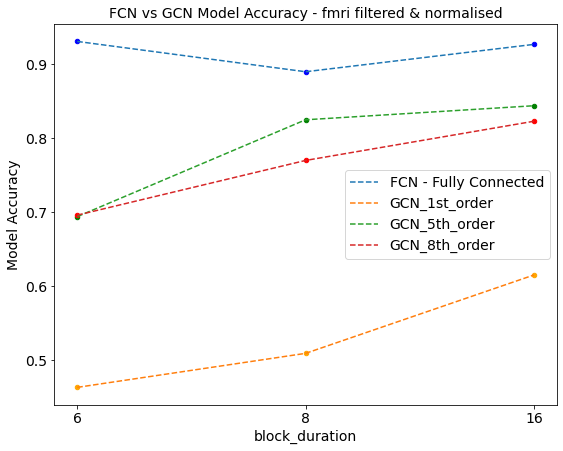

In [96]:
#Plot results
df1 = df.loc['filtered_&_norm', column_names]
df1['block_duration'] = df1.index
ax1 = df1.plot(kind='scatter', x="block_duration", y='FCN - Fully Connected', color='blue', title = 'FCN vs GCN Model Accuracy - fmri filtered & normalised', figsize=(9,7))  
ax2 = df1.plot(kind='scatter', x="block_duration", y='GCN_1st_order', color='orange', ax=ax1)  
ax3 = df1.plot(kind='scatter', x="block_duration", y='GCN_5th_order', color='g', ax=ax1)
ax3 = df1.plot(kind='scatter', x="block_duration", y='GCN_8th_order', color='r', ax=ax1)
ax4 = df1.plot(x="block_duration", y=column_names, linestyle='dashed', ax = ax1);
ax4.set_ylabel("Model Accuracy")

__ii. Filtered only__

Text(0, 0.5, 'Model Accuracy')

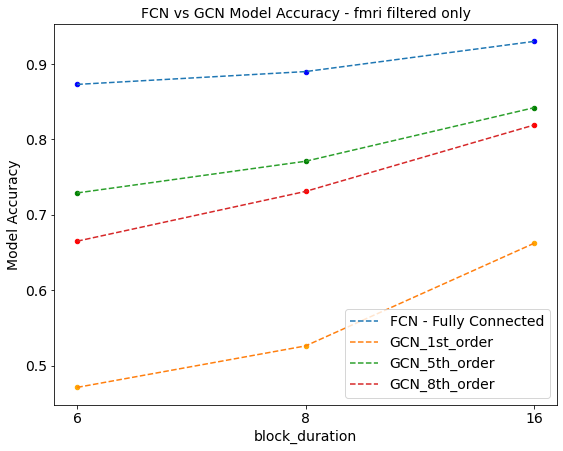

In [95]:
#Plot results
df2 = df.loc['filtered', column_names]
df2['block_duration'] = df2.index
ax1 = df2.plot(kind='scatter', x="block_duration", y='FCN - Fully Connected', color='blue', title = 'FCN vs GCN Model Accuracy - fmri filtered only', figsize=(9,7))  
ax2 = df2.plot(kind='scatter', x="block_duration", y='GCN_1st_order', color='orange', ax=ax1)  
ax3 = df2.plot(kind='scatter', x="block_duration", y='GCN_5th_order', color='g', ax=ax1)
ax3 = df2.plot(kind='scatter', x="block_duration", y='GCN_8th_order', color='r', ax=ax1)
ax4 = df2.plot(x="block_duration", y=column_names, linestyle='dashed', ax = ax1);
ax4.set_ylabel("Model Accuracy")

#### Imports <a class="anchor" id="imports"></a>

In [2]:
import os
import sys
import math
import time
import datetime

import numpy as np
import pandas as pd
import scipy.io

import nibabel as nib
from scipy import sparse
from scipy.stats import spearmanr
from sklearn import preprocessing, metrics,manifold
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from util_funcs import *
#from model import *
from models_fcn_gcn import *

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')
#%load_ext autoreload #%autoreload #%reload_ext autoreload #import sys #reload(sys)

#imports
#pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html

#CPU
device = torch.device("cpu")
print(device)

cpu


In [87]:
#Plot params
MEDIUM_SIZE = 14
BIGGER_SIZE = 17
plt.rc('font', size=MEDIUM_SIZE);
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 1. Data - fmri data <a class="anchor" id="data"></a>

In [3]:
#fmri
root_pth = '/camcan/schaefer_parc/'
fmri_movie, subj_list = get_fmri_data(root_pth, 'Movie')
print(np.array(fmri_movie).shape) #(193, 400)
print(len(subj_list)) #644 subjects
fmri_movie_copy = fmri_movie.copy()

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(644, 193, 400)
644


In [5]:
#Adjacency matrix 
root_pth = '/camcan/schaefer_parc/'
adj_mat = get_rsfmri_adj_matrix(root_pth)
#plot_corr_matrix(adj_mat)

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/sit

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std[std < np.finfo(np.float).eps] = 1.  # avoid numerical problems
/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:68: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

In [6]:
np.min(adj_mat)

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.029650910855963202

In [7]:
#Adjacency matrix
adj_mat = Adjacency_matrix(adj_mat, n_neighbours = 8).get_adj_sp_torch_tensor()
adj_mat

tensor(indices=tensor([[  1,   2,   3,  ..., 396, 397, 398],
                       [  0,   0,   0,  ..., 399, 399, 399]]),
       values=tensor([0.3348, 0.4519, 0.3895,  ..., 0.4030, 0.5090, 0.3403]),
       size=(400, 400), nnz=4198, layout=torch.sparse_coo)

In [14]:
#Params
TR = 2.47
n_subjects = np.array(fmri_movie).shape[0]
print(f'N subjects = {n_subjects}')
n_regions = np.array(fmri_movie).shape[2] 

N subjects = 644


In [9]:
#Specify block duration
block_duration = 6 #8 #16 #6 8 -Factor of 192 
total_time = fmri_movie.shape[1]
n_blocks = total_time // block_duration
n_labels = n_blocks
print(f'Number of blocks = {n_blocks}')
total_time = block_duration*n_blocks #Rounded number 
print(f'Total time = {total_time}')

Number of blocks = 32
Total time = 192


### 2.  Inspect data <a class="anchor" id="inspect_data"></a>

(193,)


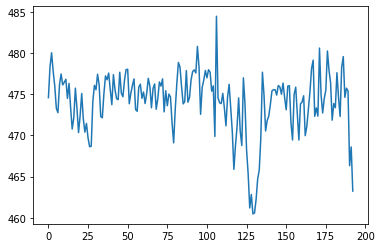

In [15]:
#Original - Plot x1 subject -1st ROI
subj_num = 1; ROI_num = 1;
fmri_1 = np.array(fmri_movie)[subj_num,:,ROI_num]
print(fmri_1.shape)
idx = range(0, len(fmri_1))
plt.plot(idx, fmri_1)

##### Normalised data

(193, 1)


/home/hannahcraddock/anaconda3/envs/hannah_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


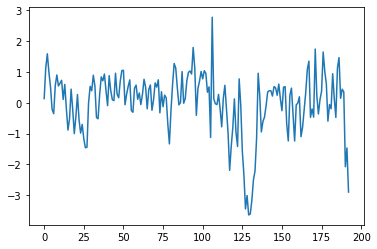

In [16]:
#Normalise
scaler = preprocessing.StandardScaler()
fmri_norm_1 = np.expand_dims(fmri_1, axis = 0).T
print(fmri_norm_1.shape)
fmri_norm_1 = scaler.fit_transform(fmri_norm_1)
plt.plot(idx, fmri_norm_1)
#plt.plot(idx, fmri_data_roi1[0,:])

##### Filtered data

In [18]:
#### Detrend data
fmri_filtered = nilearn.signal.clean(np.array(fmri_movie_copy)[1,:,:], sessions=None, detrend=True, 
                                       standardize='psc', confounds=None, low_pass=0.1, 
                                       high_pass=0.01, t_r=0.392, ensure_finite=False)
print(np.array(fmri_filtered).shape)

(193, 400)


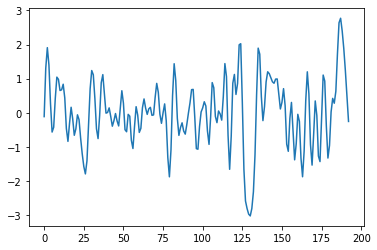

In [20]:
#Filter
fmri_filtered1 = nilearn.signal.clean(fmri_norm_1, sessions=None, detrend=True, 
                                       standardize='zscore', confounds=None, low_pass=0.1, 
                                       high_pass=0.01, t_r= TR, ensure_finite=False)
#Plot
plt.plot(idx, fmri_filtered1)

## 3. Filtered + Normalised Data <a class="anchor" id="filter_norm"></a>

In [10]:
def filter_fmri(fmri, standardize):  
    'filter fmri signal'
    
    #fmri
    fmri_filtered = []
    for subj in np.arange(0, fmri_movie_copy.shape[0]):
        fmri_subj = fmri_movie_copy[subj]
        filtered = nilearn.signal.clean(fmri_subj, sessions= None, detrend=True, 
                               standardize= False, confounds=None, low_pass= 0.1, 
                               high_pass= 0.01, t_r = TR, ensure_finite=False)
        fmri_filtered.append(filtered)
    
    return fmri_filtered

In [11]:
#Apply
standardize =  'zscore' #'psc', False
fmri_filtered = filter_fmri(fmri_movie_copy, standardize)
print(np.array(fmri_filtered).shape)

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/nilearn/signal.py:204: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not std < np.finfo(np.float).eps:


(644, 193, 400)


### 3.1  Dataloader (Train & Test sets) <a class="anchor" id="data_loader"></a>

In [12]:
#Split into train and test 
params = {'batch_size': 2, 
          'shuffle': True,
          'num_workers': 2}

test_size = 0.2
randomseed= 12345
rs = np.random.RandomState(randomseed)
#Training/Test indices
train_idx, test_idx = train_test_split(range(n_subjects), test_size = test_size, random_state=rs, shuffle=True)
print('Training on %d subjects, Testing on %d subjects' % (len(train_idx), len(test_idx)))

Training on 515 subjects, Testing on 129 subjects


In [13]:
#Train set
print(f'Block duration = {block_duration}')
fmri_data_train = [fmri_filtered[i] for i in train_idx] #Training subjects 
print(np.array(fmri_data_train).shape)
fmri_train = Fmri_dataset(fmri_data_train, TR, block_duration)
train_loader = DataLoader(fmri_train, collate_fn = fmri_samples_collate_fn, **params)

#Test set
fmri_data_test = [fmri_filtered[i] for i in test_idx]
print(np.array(fmri_data_test).shape)
fmri_test = Fmri_dataset(fmri_data_test, TR, block_duration)
test_loader = DataLoader(fmri_test, collate_fn=fmri_samples_collate_fn, **params)

Block duration = 6
(515, 193, 400)
(129, 193, 400)


### 3.2 FCN <a class="anchor" id="fcn"></a>

- Data = Filtered + Normalised

##### Block duration = 8*TR

cpu
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=24, bias=True)
  )
)
56248 paramters to be trained in the model


Epoch 0: 
Time Usage:2.089743 | Training Loss 0.047025 | Acc 0.332201
Test Loss 0.026241 | Acc 0.721899
Model updated: Best-Acc = 0.721899

Epoch 1: 
Time Usage:1.940850 | Training Loss 0.029784 | Acc 0.581068
Test Loss 0.018509 | Acc 0.802649
Model updated: Best-Acc = 0.802649

Epoch 2: 
Time Usage:2.073427 | Training Loss 0.024740 | Acc 0.653155
Test Loss 0.014441 | Acc 0.837855
Model updated: Best-Acc = 0.837855

Epoch 3: 
Time Usage:1.983021 | Training Loss 0.020553 | Acc 0.708657
Test Loss 0.016949 | Acc 0.796835

Epoch 4: 
Time Usage:2.076088 | Training Loss 0.019066 | Acc 0.736408
Test Loss 0.012225 | Acc 0.859496
Model updated: Best-Acc = 0.

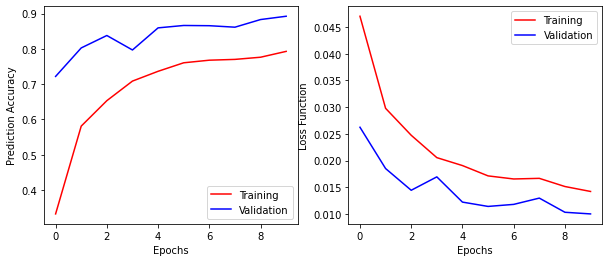

0.8924418604651163

In [40]:
#CPU
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
cpu
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=12, bias=True)
  )
)
55852 paramters to be trained in the model


Epoch 0: 
Time Usage:1.951157 | Training Loss 0.065465 | Acc 0.481715
Test Loss 0.030564 | Acc 0.819767
Model updated: Best-Acc = 0.819767

Epoch 1: 
Time Usage:1.924635 | Training Loss 0.035742 | Acc 0.743689
Test Loss 0.022310 | Acc 0.860465
Model updated: Best-Acc = 0.860465

Epoch 2: 
Time Usage:1.972935 | Training Loss 0.026227 | Acc 0.813592
Test Loss 0.016785 | Acc 0.904393
Model updated: Best-Acc = 0.904393

Epoch 3: 
Time Usage:1.945542 | Training Loss 0.022982 | Acc 0.838188
Test Loss 0.014480 | Acc 0.906977
Model updated: Best-Acc = 0.906977

Epoch 4: 
Time Usage:1.945197 | Training Loss 0.021418 | Acc 0.861003
Test Lo

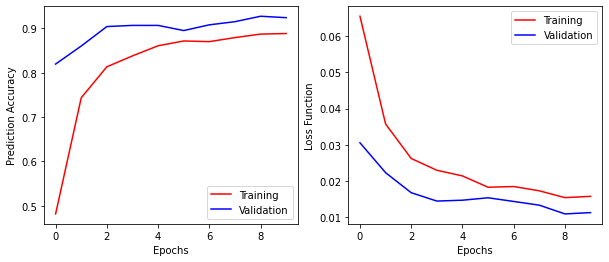

0.9276485788113695

In [44]:
print(f'Block duration = {block_duration}')

#CPU
device = torch.device("cpu")
print(device)

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 6*TR

Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.299445 | Training Loss 0.077959 | Acc 0.408576
Test Loss 0.036388 | Acc 0.741602
Model updated: Best-Acc = 0.741602

Epoch 1: 
Time Usage:1.236743 | Training Loss 0.038759 | Acc 0.691748
Test Loss 0.025278 | Acc 0.837855
Model updated: Best-Acc = 0.837855

Epoch 2: 
Time Usage:1.300997 | Training Loss 0.030223 | Acc 0.771845
Test Loss 0.019469 | Acc 0.888889
Model updated: Best-Acc = 0.888889

Epoch 3: 
Time Usage:1.274384 | Training Loss 0.026392 | Acc 0.801942
Test Loss 0.015539 | Acc 0.897287
Model updated: Best-Acc = 0.897287

Epoch 4: 
Time Usage:1.318866 | Training Loss 0.022173 | Acc 0.841909
Test Loss 0.

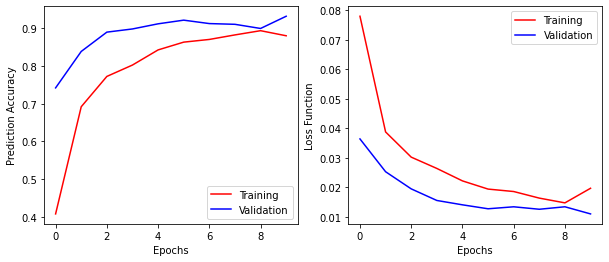

0.9308785529715762

In [48]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

### 2. GCN <a class="anchor" id="gcn"></a>

##### Block duration = 6*TR
- __First Order__

Block duration = 6
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (6 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
65280 paramters to be trained in the model


Epoch 0: 
Time Usage:225.551904 | Training Loss 0.053592 | Acc 0.050303
Test Loss 0.050195 | Acc 0.108043
Model updated: Best-Acc = 0.108043

Epoch 1: 
Time Usage:225.529149 | Training Loss 0.047543 | Acc 0.115413
Test Loss 0.043703 | Acc 0.250242
Model updated: Be

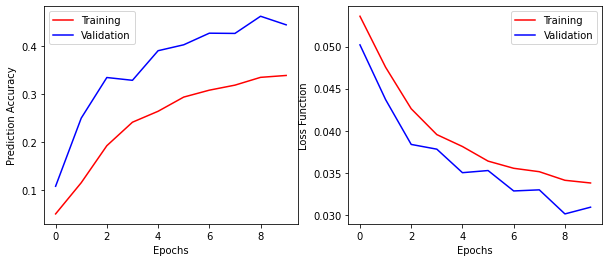

0.4629360465116279

In [52]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

#### Block duration = 6

- Fifth Order K = 5

Block duration = 6
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
76480 paramters to be trained in the model


Epoch 0: 
Time Usage:752.463936 | Training Loss 0.053702 | Acc 0.054915
Test Loss 0.051327 | Acc 0.132510
Model updated: Best-Acc = 0.132510

Epoch 1: 
Time Usage:751.202523 | Training Loss 0.046873 | Acc 0.161954
Test Loss 0.041751 | Acc 0.328004
Model updated: Best-Acc = 0.328004

Epo

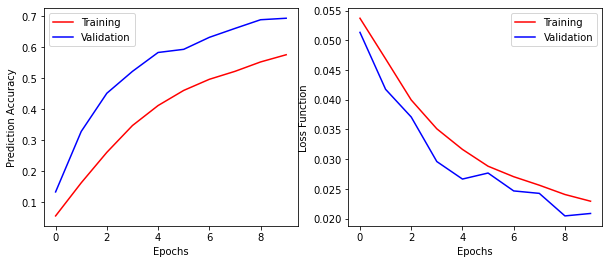

0.6940406976744186

In [53]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

Block duration = 6
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
83200 paramters to be trained in the model


Epoch 0: 
Time Usage:1201.548095 | Training Loss 0.054054 | Acc 0.044357
Test Loss 0.050579 | Acc 0.114583
Model updated: Best-Acc = 0.114583

Epoch 1: 
Time Usage:1191.653200 | Training Loss 0.047630 | Acc 0.129248
Test Loss 0.042566 | Acc 0.240552
Model updated: Best-Acc = 0.240552

E

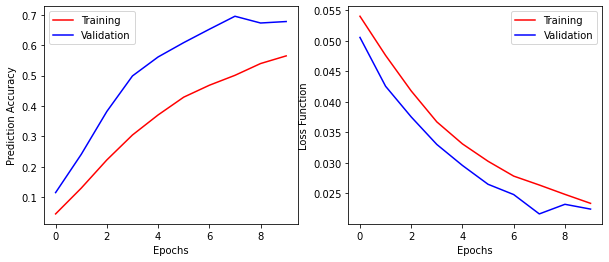

0.6957364341085271

In [60]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR
- First order

Block duration = 16
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (16 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
57720 paramters to be trained in the model


Epoch 0: 
Time Usage:73.826509 | Training Loss 0.104322 | Acc 0.084142
Test Loss 0.104347 | Acc 0.083333
Model updated: Best-Acc = 0.083333

Epoch 1: 
Time Usage:74.350230 | Training Loss 0.103725 | Acc 0.086084
Test Loss 0.103601 | Acc 0.083333

Epoch 2: 
Time U

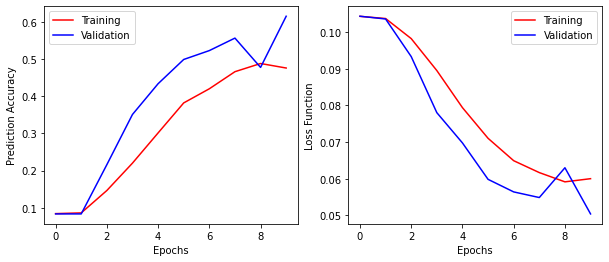

0.6149870801033591

In [45]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

__K = 5__

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
70520 paramters to be trained in the model


Epoch 0: 
Time Usage:262.898543 | Training Loss 0.099694 | Acc 0.165372
Test Loss 0.091366 | Acc 0.313307
Model updated: Best-Acc = 0.313307

Epoch 1: 
Time Usage:260.722314 | Training Loss 0.085912 | Acc 0.288188
Test Loss 0.078377 | Acc 0.463824
Model updated: Best-Acc = 0.463824

E

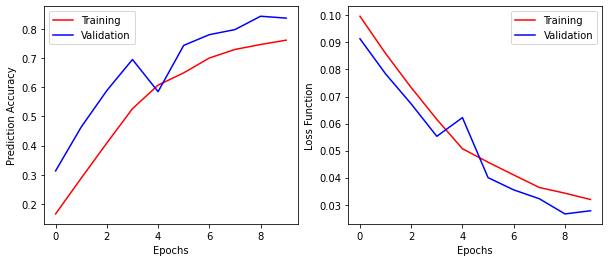

0.8443152454780362

In [46]:
#Model params 
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
78200 paramters to be trained in the model


Epoch 0: 
Time Usage:309.104297 | Training Loss 0.101765 | Acc 0.140291
Test Loss 0.086065 | Acc 0.299742
Model updated: Best-Acc = 0.299742

Epoch 1: 
Time Usage:305.677657 | Training Loss 0.081510 | Acc 0.313107
Test Loss 0.072405 | Acc 0.447674
Model updated: Best-Acc = 0.447674

E

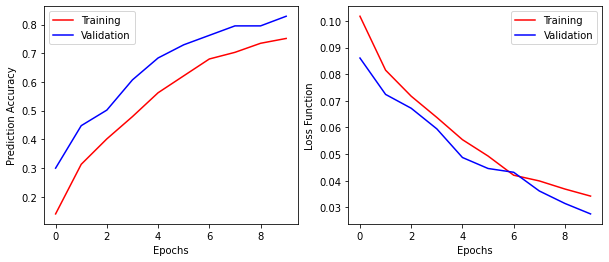

0.8288113695090439

In [65]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR
- First order

Block duration = 8
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (8 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
62192 paramters to be trained in the model


Epoch 0: 
Time Usage:136.866987 | Training Loss 0.064037 | Acc 0.084790
Test Loss 0.057415 | Acc 0.196705
Model updated: Best-Acc = 0.196705

Epoch 1: 
Time Usage:136.333657 | Training Loss 0.053554 | Acc 0.214887
Test Loss 0.048254 | Acc 0.322674
Model updated: Be

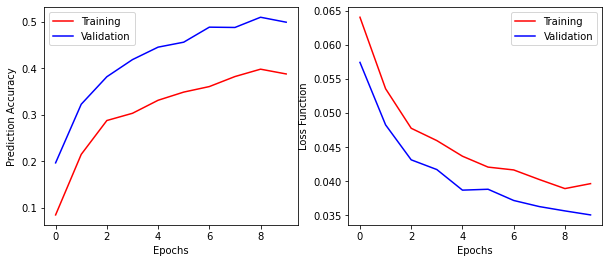

0.5096899224806202

In [72]:
from model import ChebNet

print(f'Block duration = {block_duration}')
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

__K = 5__

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
73712 paramters to be trained in the model


Epoch 0: 
Time Usage:461.768672 | Training Loss 0.063813 | Acc 0.096359
Test Loss 0.056611 | Acc 0.254199
Model updated: Best-Acc = 0.254199

Epoch 1: 
Time Usage:462.501058 | Training Loss 0.053143 | Acc 0.233900
Test Loss 0.044483 | Acc 0.389858
Model updated: Best-Acc = 0.389858

Epo

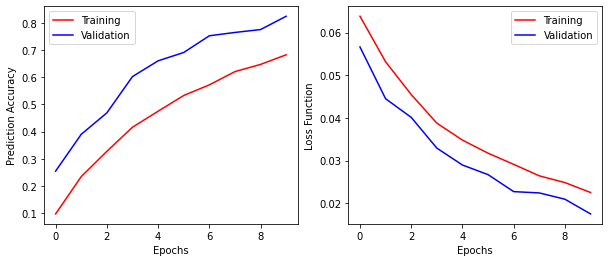

0.8252583979328165

In [73]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

__K = 8__

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
80624 paramters to be trained in the model


Epoch 0: 
Time Usage:741.675057 | Training Loss 0.066621 | Acc 0.049272
Test Loss 0.065641 | Acc 0.086886
Model updated: Best-Acc = 0.086886

Epoch 1: 
Time Usage:747.862950 | Training Loss 0.061434 | Acc 0.142071
Test Loss 0.056878 | Acc 0.290052
Model updated: Best-Acc = 0.290052

Epo

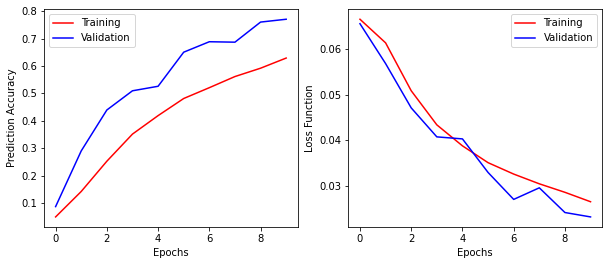

0.7703488372093024

In [74]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K= k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

## 4. Filtered + non-standardised data <a class="anchor" id="filter"></a>

In [24]:
def filter_fmri(fmri, standardize):  
    'filter fmri signal'
    
    #fmri
    fmri_filtered = []
    for subj in np.arange(0, fmri_movie_copy.shape[0]):
        fmri_subj = fmri_movie_copy[subj]
        filtered = nilearn.signal.clean(fmri_subj, sessions= None, detrend=True, 
                               standardize= False, confounds=None, low_pass= 0.1, 
                               high_pass= 0.01, t_r = TR, ensure_finite=False)
        fmri_filtered.append(filtered)
    
    return fmri_filtered

In [25]:
#Apply
standardize =  False #'psc', 'zscore'
fmri_filtered2 = filter_fmri(fmri_movie_copy, standardize)
print(np.array(fmri_filtered2).shape)

(644, 193, 400)


### 4.1  Dataloader (Train & Test sets) <a class="anchor" id="data_loader2"></a>

In [26]:
#Split into train and test 
params = {'batch_size': 2, 
          'shuffle': True,
          'num_workers': 2}

test_size = 0.2
randomseed= 12345
rs = np.random.RandomState(randomseed)
#Training/Test indices
train_idx, test_idx = train_test_split(range(n_subjects), test_size = test_size, random_state=rs, shuffle=True)
print('Training on %d subjects, Testing on %d subjects' % (len(train_idx), len(test_idx)))

Training on 515 subjects, Testing on 129 subjects


In [80]:
#Train set
print(f'Block duration = {block_duration}')
fmri_data_train = [fmri_filtered2[i] for i in train_idx] #Training subjects 
print(np.array(fmri_data_train).shape)
fmri_train = Fmri_dataset(fmri_data_train, TR, block_duration)
train_loader = DataLoader(fmri_train, collate_fn = fmri_samples_collate_fn, **params)

#Test set
fmri_data_test = [fmri_filtered2[i] for i in test_idx]
print(np.array(fmri_data_test).shape)
fmri_test = Fmri_dataset(fmri_data_test, TR, block_duration)
test_loader = DataLoader(fmri_test, collate_fn=fmri_samples_collate_fn, **params)

Block duration = 6
(515, 193, 400)
(129, 193, 400)


## 4.2 FCN <a class="anchor" id="fcn2"></a>

##### Block duration = 6*TR

Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.497382 | Training Loss 0.039517 | Acc 0.285376
Test Loss 0.026964 | Acc 0.600291
Model updated: Best-Acc = 0.600291

Epoch 1: 
Time Usage:1.465996 | Training Loss 0.026390 | Acc 0.508434
Test Loss 0.017432 | Acc 0.769864
Model updated: Best-Acc = 0.769864

Epoch 2: 
Time Usage:1.469887 | Training Loss 0.021895 | Acc 0.592476
Test Loss 0.014167 | Acc 0.817345
Model updated: Best-Acc = 0.817345

Epoch 3: 
Time Usage:1.455536 | Training Loss 0.019434 | Acc 0.638046
Test Loss 0.013387 | Acc 0.826308
Model updated: Best-Acc = 0.826308

Epoch 4: 
Time Usage:1.467361 | Training Loss 0.017893 | Acc 0.663896
Test Loss 0.

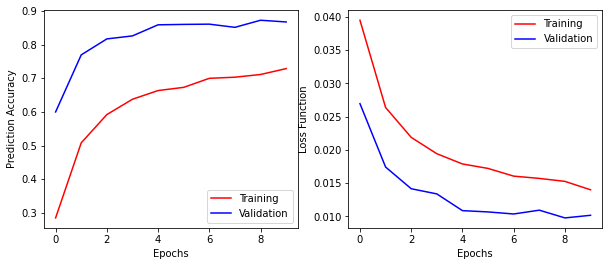

0.8728197674418605

In [55]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=12, bias=True)
  )
)
55852 paramters to be trained in the model


Epoch 0: 
Time Usage:1.231020 | Training Loss 0.065738 | Acc 0.488026
Test Loss 0.033520 | Acc 0.791990
Model updated: Best-Acc = 0.791990

Epoch 1: 
Time Usage:1.226541 | Training Loss 0.035248 | Acc 0.733657
Test Loss 0.020626 | Acc 0.874031
Model updated: Best-Acc = 0.874031

Epoch 2: 
Time Usage:1.284626 | Training Loss 0.025914 | Acc 0.818932
Test Loss 0.017252 | Acc 0.899225
Model updated: Best-Acc = 0.899225

Epoch 3: 
Time Usage:1.270998 | Training Loss 0.024466 | Acc 0.829612
Test Loss 0.020449 | Acc 0.874031

Epoch 4: 
Time Usage:1.298714 | Training Loss 0.019491 | Acc 0.860680
Test Loss 0.016229 | Acc 0.886305

Epoch 5: 
T

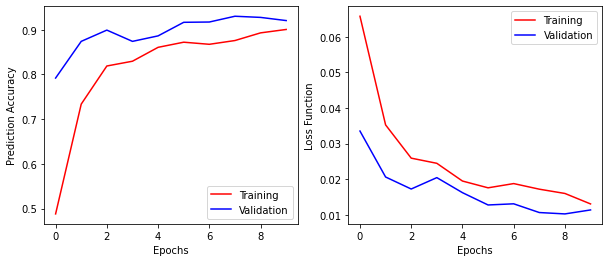

0.9302325581395349

In [28]:
#Block duration
print(f'Block duration = {block_duration}')

#Define model 
model = FCN(n_regions, n_labels) #time points == x, regions == rows 
model = model.to(device)
print(model)
print("{} paramters to be trained in the model\n".format(count_parameters(model)))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss()
num_epochs=10
#adj_mat = 'a'

model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

### 4.3. GCN <a class="anchor" id="gcn2"></a> 
- First order

##### Block duration = 6*TR

Block duration = 6
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (6 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
65280 paramters to be trained in the model


Epoch 0: 
Time Usage:225.142363 | Training Loss 0.051693 | Acc 0.072694
Test Loss 0.047066 | Acc 0.190407
Model updated: Best-Acc = 0.190407

Epoch 1: 
Time Usage:227.704138 | Training Loss 0.044640 | Acc 0.168568
Test Loss 0.039225 | Acc 0.317103
Model updated: Be

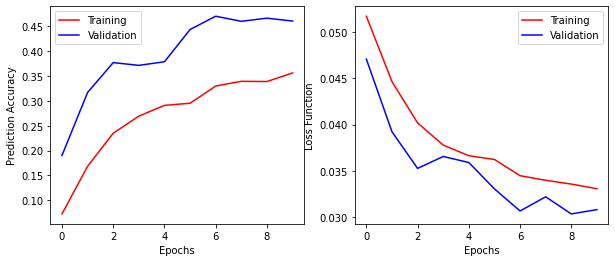

0.47044573643410853

In [56]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (8 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
62192 paramters to be trained in the model


Epoch 0: 
Time Usage:136.669055 | Training Loss 0.064165 | Acc 0.080178
Test Loss 0.057848 | Acc 0.188953
Model updated: Best-Acc = 0.188953

Epoch 1: 
Time Usage:136.768747 | Training Loss 0.053608 | Acc 0.203883
Test Loss 0.047031 | Acc 0.354005
Model updated: Be

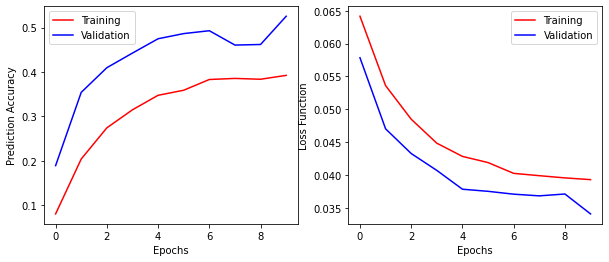

0.525516795865633

In [76]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
Using GCN Layers instead
ChebNet(
  (graph_features): ModuleList(
    (0): GraphConv (16 -> 32)
    (1): GraphConv (32 -> 32)
    (2): GraphConv (32 -> 32)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
57720 paramters to be trained in the model


Epoch 0: 
Time Usage:61.642321 | Training Loss 0.104322 | Acc 0.086084
Test Loss 0.104350 | Acc 0.083333
Model updated: Best-Acc = 0.083333

Epoch 1: 
Time Usage:60.173254 | Training Loss 0.100472 | Acc 0.124595
Test Loss 0.095063 | Acc 0.183463
Model updated: Be

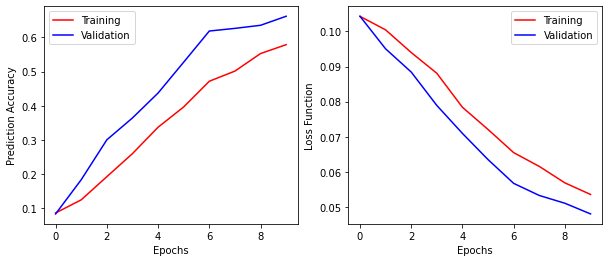

0.6621447028423773

In [29]:
from model import ChebNet
print(f'Block duration = {block_duration}')

#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 
model_test = ChebNet(block_duration, filters, n_labels, gcn_layer = num_layers,dropout=0.25,gcn_flag=True)
#model_test = ChebNet(block_dura, filters, Nlabels, K=5,gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test,adj_mat,device,train_loader,test_loader,optimizer, loss_func, num_epochs)

#### GCN - expanding to k-th order neighborhood (connecting by k steps)

##### Block duration = 6*TR

ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
76480 paramters to be trained in the model


Epoch 0: 
Time Usage:751.486356 | Training Loss 0.054330 | Acc 0.032949
Test Loss 0.053964 | Acc 0.067829
Model updated: Best-Acc = 0.067829

Epoch 1: 
Time Usage:756.365812 | Training Loss 0.050373 | Acc 0.104854
Test Loss 0.044219 | Acc 0.224806
Model updated: Best-Acc = 0.224806

Epoch 2: 
Time Usage:7

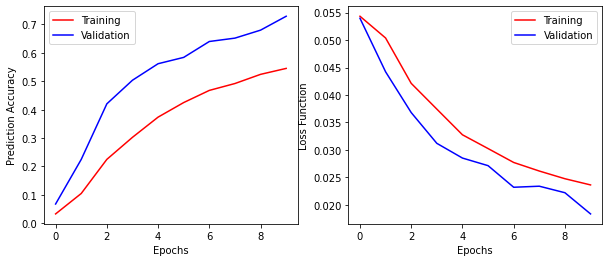

0.7289244186046512

In [57]:
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
73712 paramters to be trained in the model


Epoch 0: 
Time Usage:462.142948 | Training Loss 0.066055 | Acc 0.053641
Test Loss 0.063942 | Acc 0.129522
Model updated: Best-Acc = 0.129522

Epoch 1: 
Time Usage:466.012141 | Training Loss 0.059438 | Acc 0.141181
Test Loss 0.053810 | Acc 0.273579
Model updated: Best-Acc = 0.273579

Epo

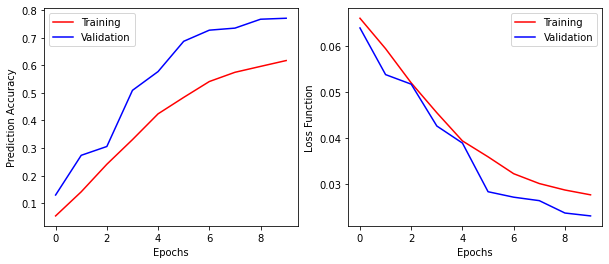

0.7709948320413437

In [77]:
#Model params 
k_order = 5
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=5)
    (1): ChebConv(32, 32, K=5)
    (2): ChebConv(32, 32, K=5)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
70520 paramters to be trained in the model


Epoch 0: 
Time Usage:201.384051 | Training Loss 0.101701 | Acc 0.130583
Test Loss 0.092205 | Acc 0.273256
Model updated: Best-Acc = 0.273256

Epoch 1: 
Time Usage:198.046426 | Training Loss 0.090437 | Acc 0.272168
Test Loss 0.078106 | Acc 0.469638
Model updated: Best-Acc = 0.469638

Epoch 2: 
Time Usage:

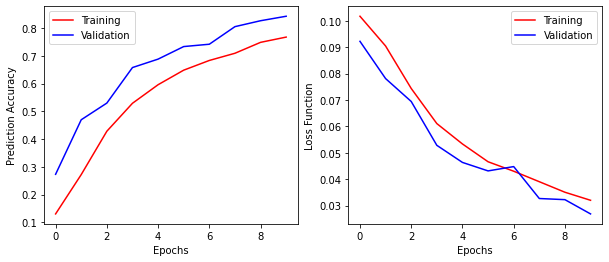

0.8423772609819121

In [30]:
#Model params 
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=5, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### K = 8

##### Block duration = 6*TR

Block duration = 6
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(6, 32, K=6)
    (1): ChebConv(32, 32, K=6)
    (2): ChebConv(32, 32, K=6)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=32, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
  )
)
78720 paramters to be trained in the model


Epoch 0: 
Time Usage:887.395731 | Training Loss 0.054989 | Acc 0.033192
Test Loss 0.054449 | Acc 0.044089
Model updated: Best-Acc = 0.044089

Epoch 1: 
Time Usage:885.944940 | Training Loss 0.050747 | Acc 0.085619
Test Loss 0.046263 | Acc 0.161579
Model updated: Best-Acc = 0.161579

Epo

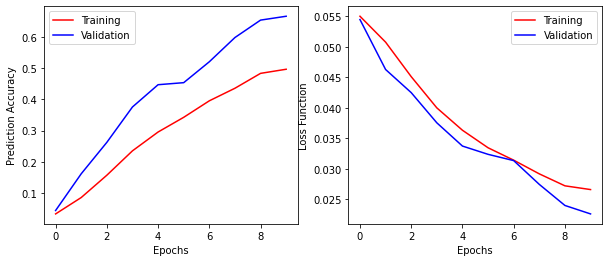

0.6654554263565892

In [81]:
#Model params 
k_order = 6
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 8*TR

Block duration = 8
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(8, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=24, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=24, bias=True)
  )
)
80624 paramters to be trained in the model


Epoch 0: 
Time Usage:739.784038 | Training Loss 0.066139 | Acc 0.055016
Test Loss 0.059645 | Acc 0.104651
Model updated: Best-Acc = 0.104651

Epoch 1: 
Time Usage:741.762217 | Training Loss 0.058464 | Acc 0.144337
Test Loss 0.053052 | Acc 0.282300
Model updated: Best-Acc = 0.282300

Epo

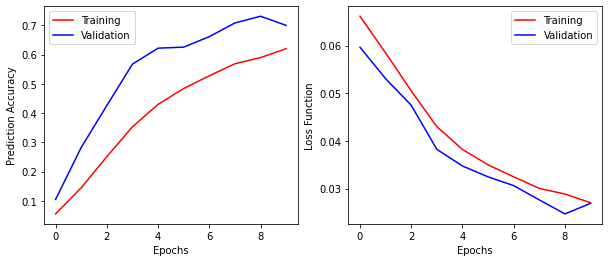

0.7309431524547804

In [78]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

##### Block duration = 16*TR

Block duration = 16
ChebNet(
  (graph_features): ModuleList(
    (0): ChebConv(16, 32, K=8)
    (1): ChebConv(32, 32, K=8)
    (2): ChebConv(32, 32, K=8)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveMaxPool2d(output_size=(360, 1))
  (linear): Linear(in_features=360, out_features=12, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=360, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=12, bias=True)
  )
)
78200 paramters to be trained in the model


Epoch 0: 
Time Usage:306.324696 | Training Loss 0.098958 | Acc 0.165534
Test Loss 0.084819 | Acc 0.308786
Model updated: Best-Acc = 0.308786

Epoch 1: 
Time Usage:305.738673 | Training Loss 0.081162 | Acc 0.333172
Test Loss 0.068377 | Acc 0.437339
Model updated: Best-Acc = 0.437339

E

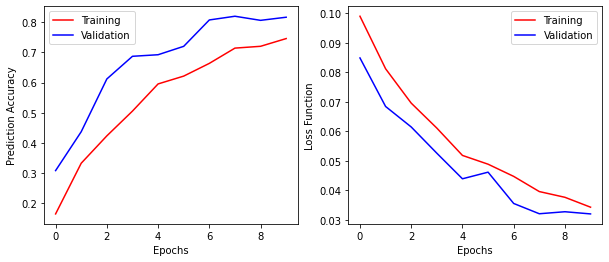

0.8191214470284238

In [67]:
#Model params 
k_order = 8
print(f'Block duration = {block_duration}')
loss_func = nn.CrossEntropyLoss()
filters = 32; num_layers = 2
num_epochs = 10 

#Model
model_test = ChebNet(block_duration, filters, n_labels, K=k_order, gcn_layer=num_layers,dropout=0.25)

model_test = model_test.to(device)
#adj_mat = adj_mat.to(device)
print(model_test)
print("{} paramters to be trained in the model\n".format(count_parameters(model_test)))

optimizer = optim.Adam(model_test.parameters(),lr=0.001, weight_decay=5e-4)

model_fit_evaluate(model_test, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)

### 5. Repeated Trials <a class="anchor" id="repeated_trials"></a> 

- FCN, block duraiton = 6

In [15]:
def run_fcn():
    
    #Block duration
    print(f'Block duration = {block_duration}')

    #Define model 
    model = FCN(n_regions, n_labels) #time points == x, regions == rows 
    model = model.to(device)
    print(model)
    print("{} paramters to be trained in the model\n".format(count_parameters(model)))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss_func = nn.CrossEntropyLoss()
    num_epochs=10
    #adj_mat = 'a'

    best_acc = model_fit_evaluate(model, adj_mat, device, train_loader, test_loader, optimizer, loss_func, num_epochs)
    
    return best_acc 

In [16]:
def get_repeated_results(n_repeats):
    'Get repeated results for fcn'
    
    dict_results = {}
    for i in np.arange(n_repeats):
        print('***************')
        print(f'Iteration = {i}')
        
        best_acc = run_fcn()
        dict_results[i] = [best_acc]
    
    df_results = pd.DataFrame(dict_results)
    
    return df_results.T

***************
Iteration = 0
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.390383 | Training Loss 0.040007 | Acc 0.283799
Test Loss 0.023573 | Acc 0.679748
Model updated: Best-Acc = 0.679748

Epoch 1: 
Time Usage:1.431946 | Training Loss 0.025345 | Acc 0.527731
Test Loss 0.019215 | Acc 0.718023
Model updated: Best-Acc = 0.718023

Epoch 2: 
Time Usage:1.403354 | Training Loss 0.022001 | Acc 0.594478
Test Loss 0.013029 | Acc 0.825339
Model updated: Best-Acc = 0.825339

Epoch 3: 
Time Usage:1.419769 | Training Loss 0.019168 | Acc 0.641262
Test Loss 0.012000 | Acc 0.833333
Model updated: Best-Acc = 0.833333

Epoch 4: 
Time Usage:1.386209 | Training Loss 0.0176

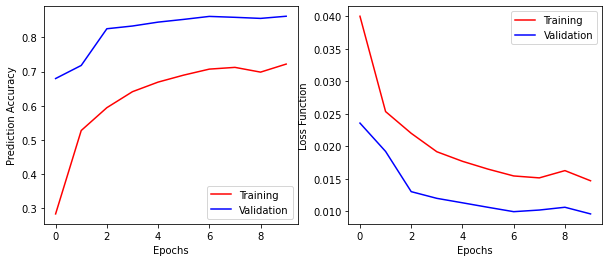

***************
Iteration = 1
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:2.410447 | Training Loss 0.039289 | Acc 0.284466
Test Loss 0.022881 | Acc 0.683140
Model updated: Best-Acc = 0.683140

Epoch 1: 
Time Usage:1.482472 | Training Loss 0.026275 | Acc 0.510862
Test Loss 0.016406 | Acc 0.772529
Model updated: Best-Acc = 0.772529

Epoch 2: 
Time Usage:1.416041 | Training Loss 0.021779 | Acc 0.593083
Test Loss 0.013798 | Acc 0.818798
Model updated: Best-Acc = 0.818798

Epoch 3: 
Time Usage:1.426116 | Training Loss 0.019820 | Acc 0.632646
Test Loss 0.012465 | Acc 0.826066
Model updated: Best-Acc = 0.826066

Epoch 4: 
Time Usage:1.475288 | Training Loss 0.0180

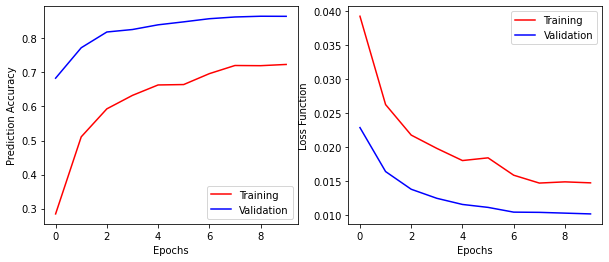

***************
Iteration = 2
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.440374 | Training Loss 0.039709 | Acc 0.276032
Test Loss 0.024586 | Acc 0.656492
Model updated: Best-Acc = 0.656492

Epoch 1: 
Time Usage:1.402281 | Training Loss 0.025990 | Acc 0.514684
Test Loss 0.016284 | Acc 0.784884
Model updated: Best-Acc = 0.784884

Epoch 2: 
Time Usage:1.391810 | Training Loss 0.021769 | Acc 0.594053
Test Loss 0.013546 | Acc 0.816376
Model updated: Best-Acc = 0.816376

Epoch 3: 
Time Usage:1.381524 | Training Loss 0.019599 | Acc 0.635983
Test Loss 0.012215 | Acc 0.832122
Model updated: Best-Acc = 0.832122

Epoch 4: 
Time Usage:1.361220 | Training Loss 0.0184

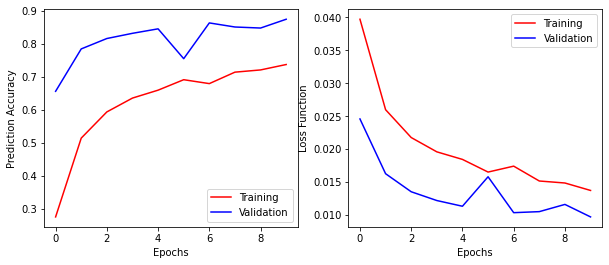

***************
Iteration = 3
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.426791 | Training Loss 0.039614 | Acc 0.286286
Test Loss 0.023596 | Acc 0.710514
Model updated: Best-Acc = 0.710514

Epoch 1: 
Time Usage:1.399964 | Training Loss 0.026476 | Acc 0.523240
Test Loss 0.016361 | Acc 0.792878
Model updated: Best-Acc = 0.792878

Epoch 2: 
Time Usage:1.407674 | Training Loss 0.021611 | Acc 0.603823
Test Loss 0.013964 | Acc 0.825339
Model updated: Best-Acc = 0.825339

Epoch 3: 
Time Usage:1.335346 | Training Loss 0.019121 | Acc 0.643629
Test Loss 0.012752 | Acc 0.830669
Model updated: Best-Acc = 0.830669

Epoch 4: 
Time Usage:1.442358 | Training Loss 0.0176

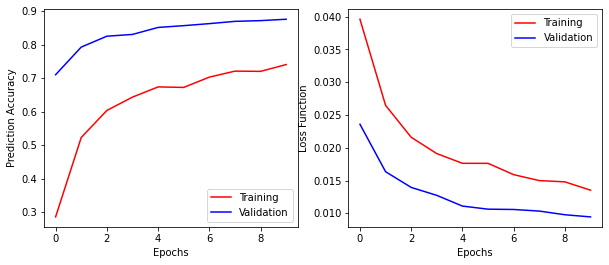

***************
Iteration = 4
Block duration = 6
FCN(
  (linear): Linear(in_features=400, out_features=128, bias=True)
  (hidden2label): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
)
56512 paramters to be trained in the model


Epoch 0: 
Time Usage:1.405623 | Training Loss 0.039378 | Acc 0.268143
Test Loss 0.023486 | Acc 0.662548
Model updated: Best-Acc = 0.662548

Epoch 1: 
Time Usage:1.635379 | Training Loss 0.026199 | Acc 0.500971
Test Loss 0.016734 | Acc 0.767200
Model updated: Best-Acc = 0.767200

Epoch 2: 
Time Usage:1.735457 | Training Loss 0.022363 | Acc 0.580886
Test Loss 0.014177 | Acc 0.802568
Model updated: Best-Acc = 0.802568

Epoch 3: 
Time Usage:1.800155 | Training Loss 0.019683 | Acc 0.628216
Test Loss 0.013486 | Acc 0.814922
Model updated: Best-Acc = 0.814922

Epoch 4: 
Time Usage:1.442590 | Training Loss 0.0184

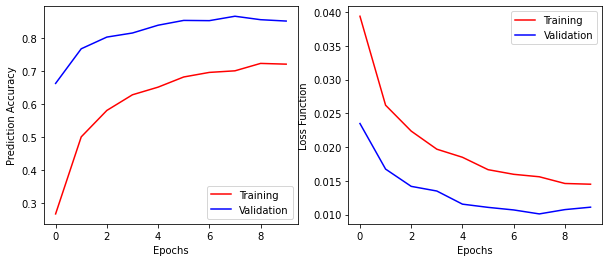

In [17]:
n_repeats = 5
df_results = get_repeated_results(n_repeats)

In [20]:
df_results.rename(columns = {0:f'Block duration = {block_duration}'}, inplace = True)
df_results

/home/hannahcraddock/anaconda3/envs/env_python38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Block duration = 6
0,0.861919
1,0.865068
2,0.874758
3,0.875969
4,0.865552
